In [78]:
# Models and metrics
import xgboost as xgb
from sklearn.calibration import calibration_curve

# Hyperparameter tuning
import hyperopt.hp as hp
from hyperopt import fmin, tpe, Trials, STATUS_OK

# Classification metrics
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, auc, brier_score_loss

# Sample weighting function for model training and evaluation
from analysis.ml.data import calculate_label_uniquness

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other imports
import pandas as pd
import numpy as np
import joblib
import os
from utils.db_utils import QUERY


In [79]:
ml_features = QUERY(
    """
    SELECT *
    FROM market_data.ml_features
    """
)

ml_features['symbol_id'] = (
    ml_features['asset_id_base'].str.upper() + 
    '_' + 
    ml_features['asset_id_quote'].str.upper() + 
    '_' + 
    ml_features['exchange_id'].str.upper()
).astype('category')

ml_features.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,symbol_id,time_period_end,asset_id_base,asset_id_quote,exchange_id,open,close,high,low,volume,...,cross_correlation_returns_365_365_ETH_rz_365,cross_correlation_returns_365_365_BTC_rz_7,cross_correlation_returns_365_365_BTC_rz_30,cross_correlation_returns_365_365_BTC_rz_90,cross_correlation_returns_365_365_BTC_rz_180,cross_correlation_returns_365_365_BTC_rz_365,triple_barrier_label_h7,trade_returns_h7,start_date_triple_barrier_label_h7,end_date_triple_barrier_label_h7
0,1INCH_USDT_BINANCE,2022-01-02,1INCH,USDT,BINANCE,2.391,2.531,2.537,2.391,6304300.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.159621,2022-01-02,2022-01-09
1,1INCH_USDT_BINANCE,2022-01-03,1INCH,USDT,BINANCE,2.532,2.556,2.582,2.466,7334248.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.159624,2022-01-03,2022-01-10
2,1INCH_USDT_BINANCE,2022-01-04,1INCH,USDT,BINANCE,2.556,2.560,2.660,2.497,11827732.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.187891,2022-01-04,2022-01-11
3,1INCH_USDT_BINANCE,2022-01-05,1INCH,USDT,BINANCE,2.560,2.481,2.600,2.459,9650025.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.133414,2022-01-05,2022-01-12
4,1INCH_USDT_BINANCE,2022-01-06,1INCH,USDT,BINANCE,2.479,2.322,2.582,2.200,13524584.0,...,0.707107,0.707107,0.707107,0.707107,0.707107,0.707107,0.0,-0.033592,2022-01-06,2022-01-13


In [81]:
a = ml_features[['time_period_end', 'volume']]
a = a.set_index('time_period_end')
a.idxmax()

volume   2024-02-29
dtype: datetime64[us]

In [37]:
p = ml_features[['time_period_end', 'symbol_id', 'returns_1']].pivot_table(index = 'time_period_end', columns = 'symbol_id', values = 'returns_1')
p.columns

CategoricalIndex(['1INCH_USDT_BINANCE', 'AAVE_USDT_BINANCE',
                  'ACH_USDT_BINANCE', 'ACM_USDT_BINANCE', 'ADA_USDT_BINANCE',
                  'ADA_USDT_HUOBI', 'ADA_USDT_OKX', 'ADA_USD_COINBASE',
                  'AGIX_USDT_BINANCE', 'AGLD_USDT_BINANCE',
                  ...
                  'UNI_USDT_BINANCE', 'USDT_DAI_BINANCE', 'VET_USDT_BINANCE',
                  'WAVES_USDT_BINANCE', 'WIF_USDT_BINANCE', 'WLD_USDT_BINANCE',
                  'WOO_USDT_BINANCE', 'XCAD_USDT_ASCENDEX', 'XCAD_USDT_GATEIO',
                  'XRP_USDT_BINANCE'],
                 categories=['1INCH_USDT_BINANCE', 'AAVE_USDT_BINANCE', 'ACH_USDT_BINANCE', 'ACM_USDT_BINANCE', ..., 'WOO_USDT_BINANCE', 'XCAD_USDT_ASCENDEX', 'XCAD_USDT_GATEIO', 'XRP_USDT_BINANCE'], ordered=False, dtype='category', name='symbol_id', length=276)

In [9]:
# Size of ml_features in GB
print(f"Size of ml_features: {ml_features.memory_usage().sum() / 1e9:.2f} GB")

# Downcast the float and integer columns to save memory
int_cols = ml_features.select_dtypes(include = 'int').columns
float_cols = ml_features.select_dtypes(include = 'float').columns

ml_features[int_cols] = ml_features[int_cols].apply(pd.to_numeric, downcast = 'integer')
ml_features[float_cols] = ml_features[float_cols].apply(pd.to_numeric, downcast = 'float')

print(f"Size of ml_features: {ml_features.memory_usage().sum() / 1e9:.2f} GB")

Size of ml_features: 9.18 GB


In [11]:
# Columns we need to drop before training the model
triple_barrier_label_cols = [
    col for col in ml_features if 'triple_barrier_label_h' in col
]

trade_returns_cols = [
    col for col in ml_features if 'trade_returns' in col
]

non_numeric_cols = [
    'asset_id_base', 'asset_id_quote', 'exchange_id', 'Unnamed: 0',
]

forward_returns_cols = [
    'open', 'high', 'low', 'close', 'start_date_triple_barrier_label_h7', 
    'end_date_triple_barrier_label_h7', 'avg_uniqueness', 'time_period_end'
]

cols_to_drop = (
    triple_barrier_label_cols + 
    trade_returns_cols + 
    non_numeric_cols +
    forward_returns_cols
)

In [12]:
ml_features['time_period_end'] = pd.to_datetime(ml_features['time_period_end'])
print(ml_features.shape)
ml_features.tail()

(191550, 6062)


,symbol_id,time_period_end,asset_id_base,asset_id_quote,exchange_id,open,close,high,low,volume,...,cross_correlation_returns_365_365_ETH_rz_365,cross_correlation_returns_365_365_BTC_rz_7,cross_correlation_returns_365_365_BTC_rz_30,cross_correlation_returns_365_365_BTC_rz_90,cross_correlation_returns_365_365_BTC_rz_180,cross_correlation_returns_365_365_BTC_rz_365,triple_barrier_label_h7,trade_returns_h7,start_date_triple_barrier_label_h7,end_date_triple_barrier_label_h7
191545,TRUE_USDT_BINANCE,2023-10-10,true,USDT,BINANCE,0.01982,0.01871,0.01989,0.01803,180006580.0,...,-0.530543,1.455492,2.018397,3.441198,0.208831,-0.360757,0.0,0.0,NaT,NaT
191546,TRUE_USDT_BINANCE,2023-10-11,true,USDT,BINANCE,0.01872,0.01885,0.01908,0.01821,169340690.0,...,-0.518568,1.416287,2.008341,3.431289,0.265652,-0.344616,0.0,0.0,NaT,NaT
191547,TRUE_USDT_BINANCE,2023-10-12,true,USDT,BINANCE,0.01885,0.01803,0.01885,0.01764,85988310.0,...,-0.506779,1.372922,1.984982,3.386723,0.322469,-0.329519,0.0,0.0,NaT,NaT
191548,TRUE_USDT_BINANCE,2023-10-13,true,USDT,BINANCE,0.01803,0.01961,0.02143,0.01802,852503600.0,...,-0.492403,1.440575,2.006445,3.389253,0.391553,-0.310181,0.0,0.0,NaT,NaT
191549,TRUE_USDT_BINANCE,2023-10-14,true,USDT,BINANCE,0.01961,0.01962,0.01964,0.01959,1864135.2,...,-0.476188,1.490868,2.032819,3.393698,0.467366,-0.289244,0.0,0.0,NaT,NaT


In [21]:
# Hyperparameter space for XGBoost
space = {
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'gamma': hp.uniform('gamma', 0, 5),

    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),

    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree':  hp.uniform('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bynode':  hp.uniform('colsample_bynode', 0.5, 1.0),
    'early_stopping_rounds': 30,
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    
    'max_bin': 500,
    'objective': 'binary:logistic',
    'n_jobs': 3,
    'random_state': 9 + 10,
    'enable_categorical': True
}

def run_hyperparameter_tuning(X_train, y_train):
    def evaluate(config):
        config['max_depth'] = int(config['max_depth'])
        config['n_estimators'] = int(config['n_estimators'])
        config['early_stopping_rounds'] = int(config['early_stopping_rounds'])
        config['n_jobs'] = int(config['n_jobs'])
        config['random_state'] = int(config['random_state'])
        config['max_bin'] = int(config['max_bin'])
        
        # Split the training set into training and validation set (time-series)
        X_train['time_period_end'] = pd.to_datetime(X_train['time_period_end'])
        date_70 = X_train['time_period_end'].quantile(0.7)
        
        X_train_split = X_train[X_train['time_period_end'] <= date_70]
        X_val_split = X_train[X_train['time_period_end'] > date_70]

        # Ensure no data leakage
        data_leakage_indicator = (
            (X_train_split['time_period_end'].max() >= X_val_split['time_period_end'].min())
        )
        assert not data_leakage_indicator, 'Data leakage detected'

        y_train_split = y_train[X_train['time_period_end'] <= date_70]
        y_val_split = y_train[X_train['time_period_end'] > date_70]

        model = xgb.XGBClassifier(**config, class_weight = 'balanced')
        evaluation = [(X_val_split.drop(columns = cols_to_drop, errors = 'ignore'), y_val_split)]
        sample_weight_train = (X_train_split['avg_uniqueness'] * X_train_split['trade_returns_h7'].abs()).fillna(1)

        # Train base model
        model.fit(
            X_train_split.drop(columns = cols_to_drop, errors = 'ignore'),
            y_train_split,
            eval_set = evaluation,
            eval_metric = 'logloss',
            # Observations weighed by the absolute value of their trade returns and
            # label uniqueness
            sample_weight = sample_weight_train,
            verbose = False
        )

        # Predicted probability of positive class
        y_pred_proba_pos = model.predict_proba(X_val_split.drop(columns = cols_to_drop, errors = 'ignore'))[:, 1]
        y_pred = model.predict(X_val_split.drop(columns = cols_to_drop, errors = 'ignore'))

        X_val_split_w_trade_returns = X_train[X_train['time_period_end'] > date_70]
        X_val_split_w_trade_returns['y_pred'] = y_pred
        X_val_split_w_trade_returns['y_true'] = y_val_split
        
        sample_weight_val = (X_val_split_w_trade_returns['avg_uniqueness'] * X_val_split_w_trade_returns['trade_returns_h7'].abs()).fillna(1)
        X_val_split_w_trade_returns['sample_weight'] = sample_weight_val

        # Fraction of total sample_weight associated with each class
        class_weight = X_val_split_w_trade_returns.groupby('y_true')['sample_weight'].sum() / X_val_split_w_trade_returns['sample_weight'].sum()
        print('Class Weight Distribution:')
        print(class_weight)
        print()

        # Calculate mean returns difference across all tokens
        pred_mean_returns_diffs = X_val_split_w_trade_returns.pivot_table(index = 'symbol_id', columns = 'y_pred', values = 'trade_returns_h7', aggfunc = 'mean')
        
        try:
            pos = pred_mean_returns_diffs[1]
        except:
            pos = 0

        try:
            neg = pred_mean_returns_diffs[0]
        except:
            neg = 0

        returns_diffs_across_symbols = pos - neg

        # Mean returns difference across all tokens on the validation set
        mean_returns_diff_across_symbols = returns_diffs_across_symbols.mean()
    
        # F1 score positive class
        f1_score_pos = f1_score(y_val_split, y_pred, pos_label = 1, sample_weight = sample_weight_val)
        # F1 score negative class
        f1_score_neg = f1_score(y_val_split, y_pred, pos_label = 0, sample_weight = sample_weight_val)
        
        # Calculate the optimization metric
        optimization_metric = (
            # Balanced F1 score between the positive and negative classes
            f1_score_pos * f1_score_neg
        )

        config['optimization_metric'] = optimization_metric

        print('Hyperparameters:', config)
        print()        
        print('Mean Returns Diff Across Tokens: ', round(mean_returns_diff_across_symbols, 3))
        print('F1 Score Positive Class: ', round(f1_score_pos, 3))
        print('F1 Score Negative Class: ', round(f1_score_neg, 3))
        print('Optimization Metric: ', round(optimization_metric, 8))
        print('-----------------------------------')
        print()

        return {
            'loss': -optimization_metric,
            'status': STATUS_OK
        }

    trials = Trials()
    best = fmin(
        fn = evaluate,
        space = space,
        algo = tpe.suggest,
        max_evals = 20,
        trials = trials
    )
    return best

In [22]:
min_year = ml_features['time_period_end'].dt.year.min()
max_year = ml_features['time_period_end'].dt.year.max()

print(f"Min Year: {min_year}")
print(f"Max Year: {max_year}")

Min Year: 2017
Max Year: 2024



Training model for 2023 july_to_sept

Number of observations: 146928

Class Weight Distribution:                           
y_true                                               
0    0.533403
1    0.466597
Name: sample_weight, dtype: float64
Hyperparameters:                                     
{'colsample_bylevel': 0.8559090842950567, 'colsample_bynode': 0.663065021208513, 'colsample_bytree': 0.5426695597771782, 'early_stopping_rounds': 30, 'enable_categorical': True, 'gamma': 1.9703766262891769, 'learning_rate': 0.27791884365191294, 'max_bin': 500, 'max_depth': 14, 'min_child_weight': 2.110134526557927, 'n_estimators': 300, 'n_jobs': 3, 'objective': 'binary:logistic', 'random_state': 19, 'reg_alpha': 2.1096227102456093, 'reg_lambda': 7.4844235156235825, 'subsample': 0.5814463054626098, 'optimization_metric': 0.31797578087258727}
Mean Returns Diff Across Tokens:                     
0.016                                                
F1 Score Positive Class:                        

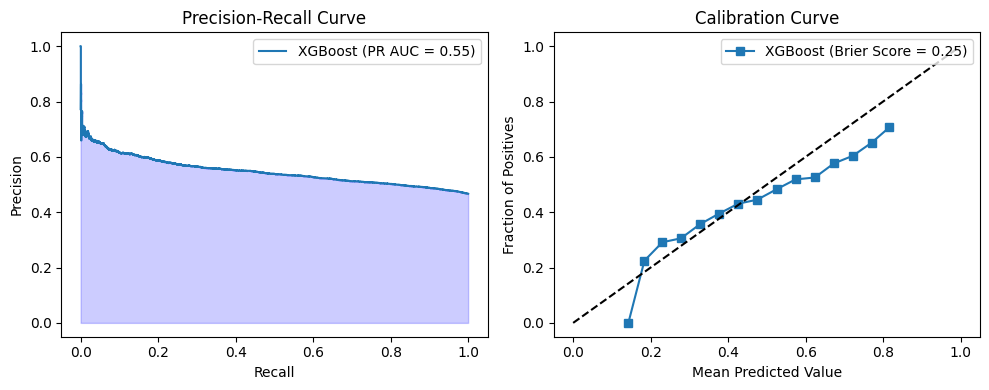

Mean Returns Diff Across Tokens:  0.016

Training model for 2023 oct_to_dec

Number of observations: 158374

Class Weight Distribution:                           
y_true                                               
0    0.505052
1    0.494948
Name: sample_weight, dtype: float64
Hyperparameters:                                     
{'colsample_bylevel': 0.5872275667593801, 'colsample_bynode': 0.5881601685501012, 'colsample_bytree': 0.648931781096536, 'early_stopping_rounds': 30, 'enable_categorical': True, 'gamma': 4.342611246152559, 'learning_rate': 0.19894364995157696, 'max_bin': 500, 'max_depth': 12, 'min_child_weight': 4.317699583728641, 'n_estimators': 250, 'n_jobs': 3, 'objective': 'binary:logistic', 'random_state': 19, 'reg_alpha': 4.289629226148689, 'reg_lambda': 3.481214557983931, 'subsample': 0.6174522348280671, 'optimization_metric': 0.35857150412830885}
Mean Returns Diff Across Tokens:                     
0.026                                                
F1 Score Posi

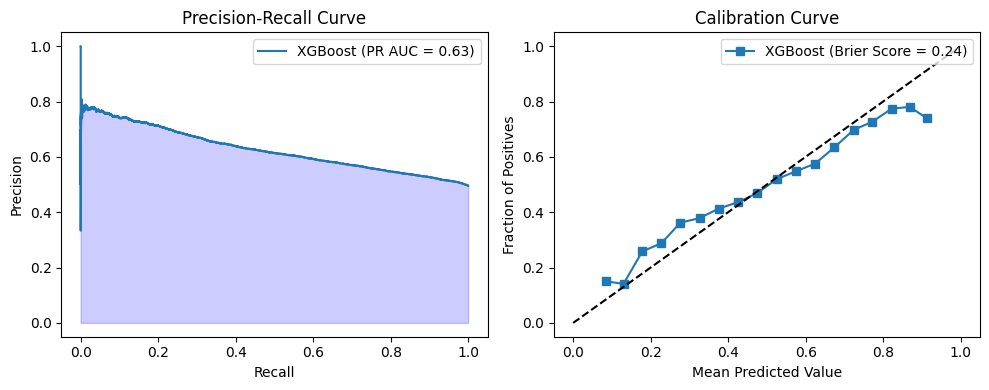

Mean Returns Diff Across Tokens:  0.026

Training model for 2024 jan_to_march

Number of observations: 167217

Class Weight Distribution:                           
y_true                                               
0    0.489556
1    0.510444
Name: sample_weight, dtype: float64
Hyperparameters:                                     
{'colsample_bylevel': 0.8492840549124543, 'colsample_bynode': 0.6038147116633751, 'colsample_bytree': 0.5009980414631527, 'early_stopping_rounds': 30, 'enable_categorical': True, 'gamma': 3.946336453472958, 'learning_rate': 0.02286120414636309, 'max_bin': 500, 'max_depth': 7, 'min_child_weight': 6.941660662827341, 'n_estimators': 150, 'n_jobs': 3, 'objective': 'binary:logistic', 'random_state': 19, 'reg_alpha': 2.6824678533083772, 'reg_lambda': 2.825683700469259, 'subsample': 0.8275382245040739, 'optimization_metric': 0.4041782750361357}
Mean Returns Diff Across Tokens:                     
0.037                                                
F1 Score Po

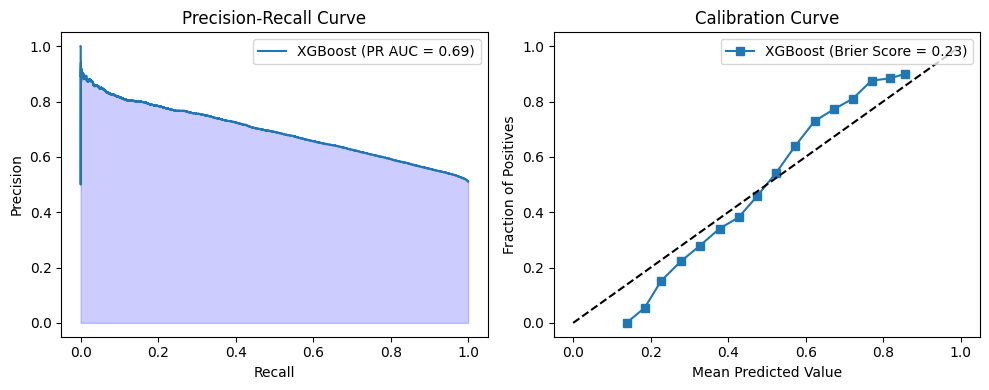

Mean Returns Diff Across Tokens:  0.037

Training model for 2024 april_to_june

Number of observations: 176034

Class Weight Distribution:                           
y_true                                               
0    0.510189
1    0.489811
Name: sample_weight, dtype: float64
Hyperparameters:                                     
{'colsample_bylevel': 0.9383004585407567, 'colsample_bynode': 0.9710447455543547, 'colsample_bytree': 0.7610919360291732, 'early_stopping_rounds': 30, 'enable_categorical': True, 'gamma': 3.9374589839624132, 'learning_rate': 0.0910448353719497, 'max_bin': 500, 'max_depth': 10, 'min_child_weight': 6.169829794163217, 'n_estimators': 250, 'n_jobs': 3, 'objective': 'binary:logistic', 'random_state': 19, 'reg_alpha': 0.793109216140136, 'reg_lambda': 2.500188481466522, 'subsample': 0.6869157254287042, 'optimization_metric': 0.38445615886195317}
Mean Returns Diff Across Tokens:                     
0.029                                                
F1 Score 

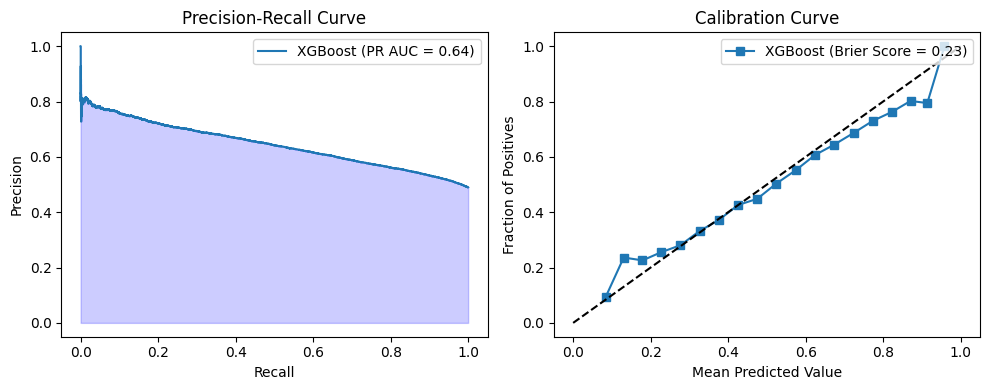

Mean Returns Diff Across Tokens:  0.029

Training model for 2024 july_to_sept

Number of observations: 184660

Class Weight Distribution:                           
y_true                                               
0    0.509557
1    0.490443
Name: sample_weight, dtype: float64
Hyperparameters:                                     
{'colsample_bylevel': 0.8817197069019498, 'colsample_bynode': 0.8966029220795931, 'colsample_bytree': 0.8600125158776175, 'early_stopping_rounds': 30, 'enable_categorical': True, 'gamma': 2.1529387502412476, 'learning_rate': 0.2568054695908637, 'max_bin': 500, 'max_depth': 13, 'min_child_weight': 4.174514960485662, 'n_estimators': 400, 'n_jobs': 3, 'objective': 'binary:logistic', 'random_state': 19, 'reg_alpha': 2.6527475308023405, 'reg_lambda': 1.378771564974977, 'subsample': 0.9574222105835397, 'optimization_metric': 0.33421575798217346}
Mean Returns Diff Across Tokens:                     
0.019                                                
F1 Score 

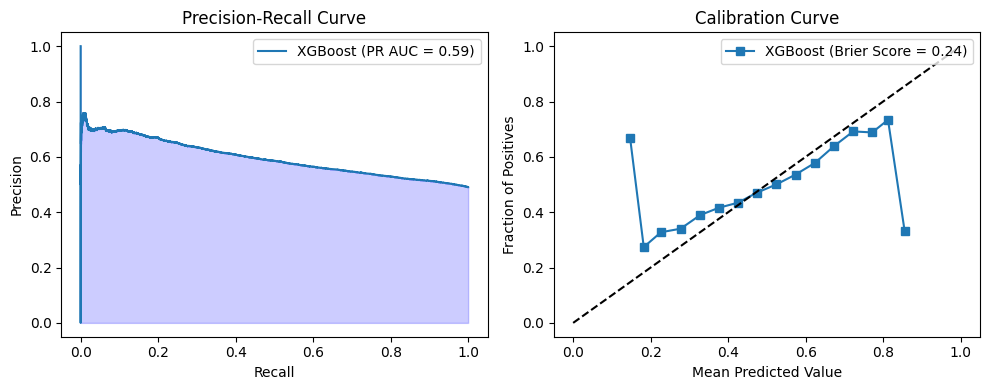

Mean Returns Diff Across Tokens:  0.019

Training model for 2024 oct_to_dec

Number of observations: 191550

Class Weight Distribution:                           
y_true                                               
0    0.500044
1    0.499956
Name: sample_weight, dtype: float64
Hyperparameters:                                     
{'colsample_bylevel': 0.9370288343794388, 'colsample_bynode': 0.8994062386394256, 'colsample_bytree': 0.9962582175352032, 'early_stopping_rounds': 30, 'enable_categorical': True, 'gamma': 3.8821858068573527, 'learning_rate': 0.1712186935055752, 'max_bin': 500, 'max_depth': 10, 'min_child_weight': 6.730044941785353, 'n_estimators': 250, 'n_jobs': 3, 'objective': 'binary:logistic', 'random_state': 19, 'reg_alpha': 0.4445580870738819, 'reg_lambda': 5.729117327079084, 'subsample': 0.6334256753852032, 'optimization_metric': 0.3675550994036159}
Mean Returns Diff Across Tokens:                     
0.027                                                
F1 Score Pos

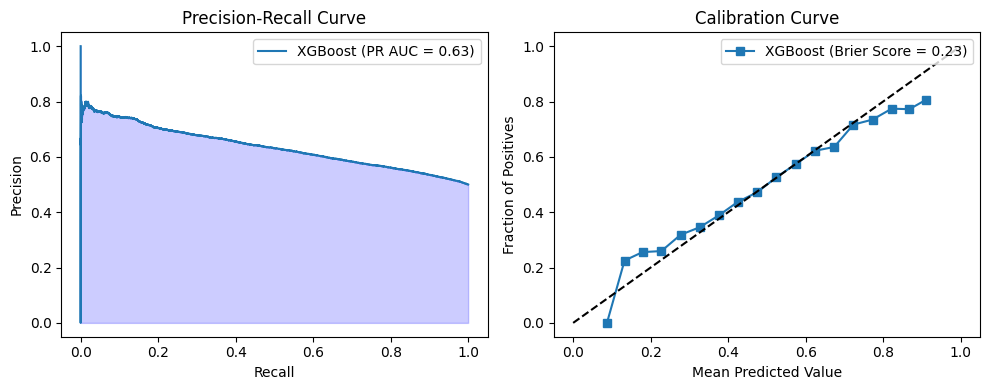

Mean Returns Diff Across Tokens:  0.027


In [23]:
# TODO: Save validation performance metrics for each model alongside the model
for year in range(min_year, max_year + 1):
    # Split year into 4 equal parts
    month_map = {'jan_to_march': [1, 2, 3], 'april_to_june': [4, 5, 6], 'july_to_sept': [7, 8, 9], 'oct_to_dec': [10, 11, 12]}

    # Train XGBoost model for each quarter and store in dictionary
    for quarter, months in month_map.items():
        
        # Filter for all data less than or equal to the year and within the quarter
        max_month = max(months)

        if year >= 2021:
            continue

        print()
        print(f'Training model for {year} {quarter}')
        print()

        data = ml_features[
            (ml_features['time_period_end'].dt.year < year) |
            ((ml_features['time_period_end'].dt.year == year) & (ml_features['time_period_end'].dt.month <= max_month))
        ]

        # Calculate the average uniqueness of each label to prevent too
        # much correlation between the labels in the training set
        data = calculate_label_uniquness(data)

        print(f'Number of observations: {data.shape[0]}')
        print()

        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data['symbol_id'] = data['symbol_id'].astype('category')

        if data.empty:
            continue

        # Split data into features and target
        X = data
        y = ((data['triple_barrier_label_h7'] == 1) | ((data['triple_barrier_label_h7'] == 0) & (data['trade_returns_h7'] > 0))).astype(int)

        # Run hyperparameter tuning on XGBoost model and store the best tuned model

        # Get the best hyperparameters for the model on the year and quarter
        best_hyperparameters = run_hyperparameter_tuning(X, y)

        # # Train the model with the best hyperparameters
        best_hyperparameters['max_depth'] = int(best_hyperparameters['max_depth'])
        best_hyperparameters['n_estimators'] = int(best_hyperparameters['n_estimators'])
        best_hyperparameters['n_jobs'] = os.cpu_count() // 2
        best_hyperparameters['random_state'] = 9 + 10
        best_hyperparameters['objective'] = 'binary:logistic'
        best_hyperparameters['enable_categorical'] = True
        best_hyperparameters['max_bin'] = 500
        best_hyperparameters['early_stopping_rounds'] = 30

        # Split the training set into training and validation set (time-series)
        X['time_period_end'] = pd.to_datetime(X['time_period_end'])
        date_70 = X['time_period_end'].quantile(0.7)

        X_train_split = X[X['time_period_end'] <= date_70]
        X_train_split['symbol_id'] = X_train_split['symbol_id'].astype('category')

        X_val_split = X[X['time_period_end'] > date_70]
        X_val_split['symbol_id'] = X_val_split['symbol_id'].astype('category')

        # Ensure no data leakage
        data_leakage_indicator = (
            (X_train_split['time_period_end'].max() >= X_val_split['time_period_end'].min())
        )
        assert not data_leakage_indicator, 'Data leakage detected'

        y_train_split = y[X['time_period_end'] <= date_70]
        y_val_split = y[X['time_period_end'] > date_70]

        model = xgb.XGBClassifier(**best_hyperparameters, class_weight = 'balanced')
        evaluation = [(X_val_split.drop(columns = cols_to_drop, errors = 'ignore'), y_val_split)]
        sample_weight_train = (X_train_split['avg_uniqueness'] * X_train_split['trade_returns_h7'].abs()).fillna(1)

        model.fit(
            X_train_split.drop(columns = cols_to_drop, errors = 'ignore'),
            y_train_split,
            eval_set = evaluation,
            eval_metric = 'logloss',
            # Observations weighed by the absolute value of their trade returns and
            # label uniqueness
            sample_weight = sample_weight_train,
            verbose = False
        )

        y_pred_proba = model.predict_proba(X_val_split.drop(columns = cols_to_drop, errors = 'ignore'))[:, 1]
        y_pred = model.predict(X_val_split.drop(columns = cols_to_drop, errors = 'ignore'))
        y_true = y_val_split

        # Distribution of sample_weight across both classes
        X_val_split_w_trade_returns = X_val_split
        X_val_split_w_trade_returns['y_pred'] = y_pred
        X_val_split_w_trade_returns['y_true'] = y_true

        sample_weight_val = (X_val_split_w_trade_returns['avg_uniqueness'] * X_val_split_w_trade_returns['trade_returns_h7'].abs()).fillna(1)
        X_val_split_w_trade_returns['sample_weight'] = sample_weight_val
        
        # Fraction of total sample_weight associated with each class
        class_weight = X_val_split_w_trade_returns.groupby('y_true')['sample_weight'].sum() / X_val_split_w_trade_returns['sample_weight'].sum()
        print('Class Weight Distribution:')
        print(class_weight)
        print()
        
        # Classification report
        print('Classification Report')
        print(classification_report(y_true, y_pred, sample_weight = sample_weight_val)) 
        print()

        fig, axs = plt.subplots(1, 2, figsize = (10, 4))

        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba, sample_weight = sample_weight_val)
        pr_auc = auc(recall, precision)

        axs[0].plot(recall, precision, label = f'XGBoost (PR AUC = {pr_auc:.2f})')
        axs[0].set_xlabel('Recall')
        axs[0].set_ylabel('Precision')
        axs[0].set_title('Precision-Recall Curve')
        axs[0].legend(loc = 'upper right')

        # Fill area under the curve
        axs[0].fill_between(recall, precision, alpha = 0.2, color = 'b')

        brier_score = brier_score_loss(y_true, y_pred_proba, sample_weight = sample_weight_val)

        # Calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_proba, n_bins = 20)
        axs[1].plot(mean_predicted_value, fraction_of_positives, marker = 's', label = f'XGBoost (Brier Score = {brier_score:.2f})')
        axs[1].plot([0, 1], [0, 1], linestyle = '--', color = 'black')
        axs[1].set_xlabel('Mean Predicted Value')
        axs[1].set_ylabel('Fraction of Positives')
        axs[1].set_title('Calibration Curve')
        axs[1].legend(loc = 'upper right')

        plt.tight_layout()
        plt.show()

        # Mean returns difference across all tokens
        X_val_split_w_trade_returns = X_val_split
        X_val_split_w_trade_returns['y_pred'] = y_pred
        pred_mean_returns_diffs = X_val_split_w_trade_returns.pivot_table(index = 'symbol_id', columns = 'y_pred', values = 'trade_returns_h7', aggfunc = 'mean')

        try:
            pos = pred_mean_returns_diffs[1]
        except:
            pos = 0

        try:
            neg = pred_mean_returns_diffs[0]
        except:
            neg = 0

        returns_diffs_across_symbols = pos - neg

        # Mean returns difference across all tokens on the validation set
        mean_returns_diff_across_symbols = returns_diffs_across_symbols.mean()
        print('Mean Returns Diff Across Tokens: ', round(mean_returns_diff_across_symbols, 3))

        # Save the calibrated model and performance metrics
        path = f'/Users/louisspencer/Desktop/Trading-Bot/data/pretrained_models/classification/xgboost_model_and_metrics_{year}_{quarter}.pkl'

        # Performance metrics to save alongside the model
        model_performance = {
            'classification_report': classification_report(y_true, y_pred, output_dict = True),
            'pr_auc': pr_auc,
            'mean_returns_diff_across_symbols': mean_returns_diff_across_symbols
        }

        # Save model performance metrics and model
        joblib.dump((model, model_performance), path)
